
# DAMO600 — Prescriptive Analytics  
## Module 7 (Part 2): Practice Question & Key Components of Simulation Models

This notebook implements **Part 2** of Module 7 using your provided instructional content:

- Practice question on a bank/teller system
- Step-by-step calculations: average wait time and teller utilization
- Extension to two tellers and more customers
- Introducing random elements (inter-arrival and service distributions)
- A minimal **discrete-event simulation (DES)** implementation in Python
- A summary of **key components** of simulation models



## 1) Practice Question — Average Customer Wait Time

We are given 5 customers with the following **wait times** (minutes):

- Customer 1: 0 (immediate service)  
- Customer 2: 1 (waited from 3 to 4)  
- Customer 3: 0 (immediate service)  
- Customer 4: 3 (waited from 9 to 12)  
- Customer 5: 0 (immediate service)  

**Total wait** = 0 + 1 + 0 + 3 + 0 = **4** minutes.  
**Number of customers** = **5**.  
**Average wait time** = 4 / 5 = **0.8 minutes**.


In [2]:

# Step 1: Verify average wait calculation
waits = [0, 1, 0, 3, 0]
avg_wait = sum(waits) / len(waits)
avg_wait


0.8


## 2) Practice Question — Teller Utilization

- **Total simulation time** = 18 minutes  
- **Service times** (sum) = 4 + 3 + 5 + 2 + 3 = **17** minutes  
- **Utilization** = 17 / 18 = **94.44%**


In [3]:

# Step 2: Verify teller utilization
total_time = 18
service_times = [4, 3, 5, 2, 3]
utilization = sum(service_times) / total_time
utilization * 100


94.44444444444444


## 3) Extension — Two Tellers + More Customers

We extend the example to **two tellers** and add three more customers. The provided event table looks like this (selected fields shown):

| Event | Clock | Inter-arrival | Arrival | Service | Teller 1 Start | Teller 1 End | Teller 2 Start | Teller 2 End | Queue |
|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| E1 | 0  | 5 | 0  | 4 | 0  | 4  | –  | –  | 0 |
| E2 | 3  | 3 | 3  | 3 | –  | –  | 3  | 6  | 0 |
| E3 | 7  | 4 | 7  | 5 | 7  | 12 | –  | –  | 0 |
| E4 | 9  | 2 | 9  | 2 | –  | –  | 9  | 11 | 0 |
| E5 | 15 | 6 | 15 | 3 | 15 | 18 | –  | –  | 0 |
| E6 | 18 | 3 | 18 | 4 | 18 | 22 | –  | –  | 0 |
| E7 | 20 | 2 | 20 | 3 | –  | –  | 20 | 23 | 0 |
| E8 | 24 | 4 | 24 | 5 | 24 | 29 | –  | –  | 0 |

Below we implement a small **two-server FCFS** scheduler and compute standard metrics.


In [4]:

# Two-teller FCFS scheduler for deterministic arrivals & service times
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class EventLog:
    customer: int
    arrival: float
    service: float
    start: float
    end: float
    server: int

def simulate_two_servers(arrivals: List[float], services: List[float], num_servers: int = 2):
    # Track next-available time for each server
    available_at = [0.0 for _ in range(num_servers)]
    logs: List[EventLog] = []
    queue: List[int] = []  # indexes of waiting customers (FCFS)
    
    # We'll process customers in order; when they arrive,
    # assign them to the earliest available server (if available now),
    # otherwise they wait in the queue until a server frees up.
    current_time = 0.0
    n = len(arrivals)
    
    # Sort by arrival order (already sorted, but let's be safe)
    order = sorted(range(n), key=lambda i: arrivals[i])
    
    for idx in order:
        arrival = arrivals[idx]
        service = services[idx]
        current_time = max(current_time, arrival)
        
        # Find server that becomes free the earliest
        s = min(range(num_servers), key=lambda k: available_at[k])
        start_time = max(arrival, available_at[s])
        end_time = start_time + service
        
        logs.append(EventLog(customer=idx+1, arrival=arrival, service=service, start=start_time, end=end_time, server=s))
        available_at[s] = end_time
    
    return logs

# Use the Arrival/Service pairs from the extended table (E1..E8) as arrival/service times.
arrivals = [0, 3, 7, 9, 15, 18, 20, 24]
services = [4, 3, 5, 2, 3, 4, 3, 5]

logs = simulate_two_servers(arrivals, services, num_servers=2)

# Compute metrics
avg_wait = sum(log.start - log.arrival for log in logs) / len(logs)
util_by_server = {}
for s in set(l.server for l in logs):
    busy = sum(l.end - l.start for l in logs if l.server == s)
    horizon = max(l.end for l in logs)
    util_by_server[s] = busy / horizon

avg_wait, util_by_server, [(l.customer, l.server, l.arrival, l.start, l.end) for l in logs]


(0.0,
 {0: 0.6206896551724138, 1: 0.3793103448275862},
 [(1, 0, 0, 0, 4),
  (2, 1, 3, 3, 6),
  (3, 0, 7, 7, 12),
  (4, 1, 9, 9, 11),
  (5, 1, 15, 15, 18),
  (6, 0, 18, 18, 22),
  (7, 1, 20, 20, 23),
  (8, 0, 24, 24, 29)])


## 4) Introducing Random Elements

We now **randomize** inter-arrival and service times using common distributions:

- **Inter-arrival times**: Exponential with mean 4 minutes  
- **Service times**: Normal with mean 3.5 minutes and standard deviation 1 minute

We'll generate a small sample to illustrate.


In [8]:

import numpy as np

np.random.seed(42)  # reproducibility

inter_arrival_times = np.random.exponential(scale=4, size=10)
service_times_sample = np.random.normal(loc=3.5, scale=1.0, size=10)

print("Inter-arrival times:", np.round(inter_arrival_times, 3))
print("Service times:", np.round(service_times_sample, 3))


Inter-arrival times: [ 1.877 12.04   5.267  3.652  0.678  0.678  0.239  8.045  3.676  4.925]
Service times: [3.031 4.043 3.037 3.034 3.742 1.587 1.775 2.938 2.487 3.814]


In [9]:

# Convert inter-arrival times to absolute arrival times, then simulate with two servers.
import numpy as np

arrivals_random = np.cumsum(inter_arrival_times)
services_random = np.clip(service_times_sample, 0.2, None)  # clip to avoid negative/zero times

logs_random = simulate_two_servers(arrivals_random.tolist(), services_random.tolist(), num_servers=2)

avg_wait_random = np.mean([l.start - l.arrival for l in logs_random])
horizon_random = max(l.end for l in logs_random)
util_by_server_random = {}
for s in set(l.server for l in logs_random):
    busy = sum(l.end - l.start for l in logs_random if l.server == s)
    util_by_server_random[s] = busy / horizon_random

avg_wait_random, util_by_server_random


(np.float64(0.4501607626394829),
 {0: 0.313440969133228, 1: 0.34338298900729786})

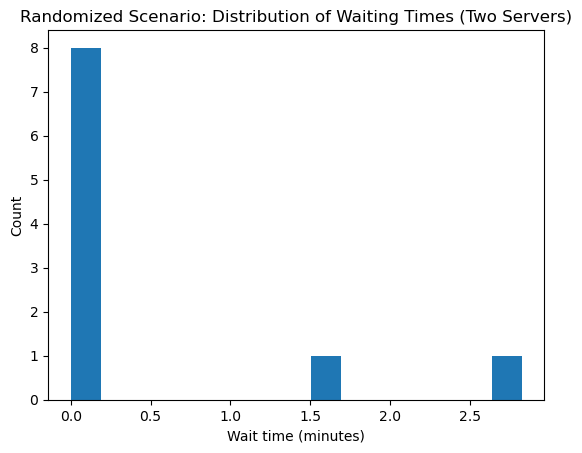

In [10]:

# Plot queueing performance proxies (waiting times histogram) using matplotlib (no seaborn, no styles)
import matplotlib.pyplot as plt

waits = [l.start - l.arrival for l in logs_random]

plt.figure()
plt.hist(waits, bins=15, density=False)
plt.title("Randomized Scenario: Distribution of Waiting Times (Two Servers)")
plt.xlabel("Wait time (minutes)")
plt.ylabel("Count")
plt.show()



## 5) Minimal DES in Pure Python (Single Teller)

Below is a pure-Python **discrete-event** simulation for a **single teller**, using the original 5 customers.
It produces an **event log** similar to the expected output.


In [11]:

# Minimal DES for a single teller (deterministic arrivals & services)
# Expected arrivals: [0, 3, 7, 9, 15]
# Expected services: [4, 3, 5, 2, 3]

arrivals_det = [0, 3, 7, 9, 15]
services_det = [4, 3, 5, 2, 3]

teller_free_at = 0.0
print_log = []
for i, (arr, svc) in enumerate(zip(arrivals_det, services_det), start=1):
    print_log.append(f"Customer {i} arrives at {arr:.2f}")
    start = max(arr, teller_free_at)
    print_log.append(f"Customer {i} starts service at {start:.2f}")
    end = start + svc
    print_log.append(f"Customer {i} departs at {end:.2f}")
    teller_free_at = end

print("\n".join(print_log))


Customer 1 arrives at 0.00
Customer 1 starts service at 0.00
Customer 1 departs at 4.00
Customer 2 arrives at 3.00
Customer 2 starts service at 4.00
Customer 2 departs at 7.00
Customer 3 arrives at 7.00
Customer 3 starts service at 7.00
Customer 3 departs at 12.00
Customer 4 arrives at 9.00
Customer 4 starts service at 12.00
Customer 4 departs at 14.00
Customer 5 arrives at 15.00
Customer 5 starts service at 15.00
Customer 5 departs at 18.00



## 6) Key Components of Simulation Models

- **Entities**: Distinct objects that move through the system (e.g., clients, orders, packets) with attributes (arrival time, priority, service need).  
- **Activities & Events**: Activities are operations entities undergo; **events** are instantaneous changes in system state (arrival, service completion, breakdown).  
- **State Variables**: Describe the current condition of the system (queue length, server status, resource levels).  
- **Resources**: Limited-capacity assets (tellers, machines, OR rooms) that entities seize and release; capacity and scheduling constraints matter.  
- **Logical Structure**: The process flow and decision rules (routing, priorities, balking/reneging, batching) that govern entity movement and resource allocation.  
- **Random Numbers & Distributions**: Mechanisms that inject stochasticity (inter-arrival/service times, breakdowns). Choice of distributions and parameters should be evidence-based.



## 7) Checks for Understanding

1. Re-run the two-teller scheduler with different arrival/service patterns. How do **average wait** and **utilization** shift?  
2. Replace the exponential inter-arrivals with **Erlang** or **lognormal**. What changes in tail behaviour of waits?  
3. Add **priority**: VIP customers preempt the queue. How would you encode this in the scheduler?
